In [2]:
!pip install torch_geometric
import torch
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
import numpy as np
import pandas as pd
import sys
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.optim as optim
import glob
import os
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import time
from torch_geometric.nn import NNConv as MyNNConv, TopKPooling
import scipy.io
import scipy.sparse as sp
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from FVE_GCN_utils import *


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 208.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 374.0 MB/s eta 0:00:00
    tinycss2 (>=1.1.0<1.2) ; extra == 'css'
             ~~~~~~~~^
    torch (>=1.10.0+cu113<1.11.0)
           ~~~~~~~~^


For GCN model, run:

In [ ]:
python FVE_GCN_script.py --job_nickname "FVE_test" --model_type "base" \
  --lr 0.001 --weight_decay 0.0001 --epochs 1 --patience 5  \
  --partial_dat --norm_y --scaler_name "standard" --batch_size 20

# Data Pre-processing

In [ ]:
partial_dat = True

if partial_dat:
    FVE_df_org = pd.read_csv("data/FVE_dat_partial.csv")
    SurfeView_surfaces = scipy.io.loadmat('data/SurfeView_surfaces.mat')
    non_surface_area_vars = ['nihtbx_cryst_uncorrected']

else:
    FVE_df_org = pd.read_csv("data/FVE_dat.csv")
    SurfeView_surfaces = scipy.io.loadmat('data/SurfeView_surfaces.mat')

    non_surface_area_vars = ['interview_age', 'sex_2',  'nihtbx_cryst_uncorrected'] #when FVE_Dat


# GCN

In [ ]:
norm_y = True
icld_age_sex= False
scaler_name = "standard"
batch_size = 20
train_loader, val_loader, test_loader = input_to_graph(SurfeView_surfaces=SurfeView_surfaces, FVE_df_all=FVE_df_org,
                                                       partial_dat=partial_dat, scaler=scaler_name,
                                                       norm_y=norm_y, icld_age_sex=icld_age_sex, batch_size=batch_size)

/niddk-data-central/mae_hr/FVE/FVE_GCN_utils.py:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_feat = torch.tensor(torch.cat([X, age_expanded, sex_expanded], dim=2), dtype=torch.float32)


icld_age_sex = True, node_feat.shape: torch.Size([7264, 20484, 3])
icld_age_sex = True, node_feat.shape: torch.Size([1816, 20484, 3])
icld_age_sex = True, node_feat.shape: torch.Size([2271, 20484, 3])


In [ ]:
boolean_map = {0:'F', 1:'T'}
job_nickname = "GCN_std"
lr = 0.001
weight_decay = 0.0001
epochs = 200
patience = 5

job_full_nickname = f"{job_nickname}_partial{boolean_map[partial_dat]}_cov{boolean_map[icld_age_sex]}_p{patience}_norm{boolean_map[norm_y]}"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open(f"/niddk-data-central/mae_hr/FVE/GCN_models/{job_full_nickname}.txt", "w") as f:
    print("Writing model output... \n", file=f, flush=True)
    print(f"Start training at {time.ctime(time.time())}", file=f, flush=True)
    print(f"epochs={epochs}, patience={patience}, batch_size={batch_size}, norm={norm_y}, partial={partial_dat}, age/sex={icld_age_sex}, scaler={scaler_name}, device={device}", file=f, flush=True)
    
    model = GCN(num_node_features=3).to(device)  


    trained_model = train_model(model=model, train_loader=train_loader, test_loader=val_loader,
                                lr=lr, weight_decay=weight_decay, epochs=epochs, patience=patience, log=f, device=device)
    

    
    torch.save(trained_model, f"/niddk-data-central/mae_hr/FVE/GCN_models/{job_full_nickname}_full.pt")

    print(f"Start eval at {time.ctime(time.time())}", file=f, flush=True)


    trained_model.eval()
    y_pred, y_true = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)

            out = trained_model(batch.x, batch.edge_index, batch.batch)#, batch.edge_attr, batch.pos)

            y_pred.extend(out.cpu().numpy().flatten())  
            y_true.extend(batch.y.cpu().numpy().flatten())  

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print(f'R2 Score: {r2:.4f}, MSE: {mse:.4f}', file=f, flush=True)
    

 

lr=0.001, weight_decay=0.0001


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 001 | Train Loss: 6650.806072 | Test Loss: 5748.920909 Tue Sep 30 00:21:25 2025
Epoch 002 | Train Loss: 4811.294144 | Test Loss: 3909.496606 Tue Sep 30 00:33:51 2025
Epoch 003 | Train Loss: 2959.888361 | Test Loss: 2118.688423 Tue Sep 30 01:02:14 2025
Epoch 004 | Train Loss: 1415.293080 | Test Loss: 861.312845 Tue Sep 30 01:56:17 2025
Epoch 005 | Train Loss: 502.559131 | Test Loss: 260.900248 Tue Sep 30 02:49:12 2025
Epoch 006 | Train Loss: 145.272454 | Test Loss: 82.919231 Tue Sep 30 03:43:42 2025
Epoch 007 | Train Loss: 61.477251 | Test Loss: 53.128987 Tue Sep 30 04:37:24 2025


R2 Score: 0.0432, MSE: 0.0114


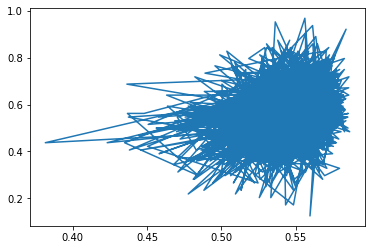

In [ ]:
from FVE_GCN_script import *



# if retreiving from just weights
model = GCN(num_node_features=1).to(device)
state_dict = torch.load("GCN_models/best_models/base_adam_lr0.001_wd0.0001-org.pt")
model.load_state_dict(state_dict)
# if retreiving from just weights

# if retreiving from whole model
#model = torch.load("GCN_models/Base_adam_FVE_dat_p5_lr0.001_wd0.0001_full.pt")
#model.eval()
# if retreiving from whole model



y_pred, y_true = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)

        out = model(batch.x, batch.edge_index, batch.batch)#, batch.edge_attr, batch.pos)
        #out = model(batch.x, batch.edge_index, batch.batch)
        y_pred.extend(out.cpu().numpy().flatten())  
        y_true.extend(batch.y.cpu().numpy().flatten())  

y_pred = np.array(y_pred)
y_true = np.array(y_true)

SSRES = np.sum((y_true - y_pred)^2)
SSTOT = np.sum((y_true-np.mean(y_true))^2)
MyR2 = 1- (SSRES/SSTOT)         
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print(f'R2 Score: {r2:.4f}, myR2: {MyR2:.4f}, MSE: {mse:.4f}')

import matplotlib.pyplot as plt
plt.plot(y_pred, y_true)



# CNN

In [56]:
def voxel_grid_to_tensor(voxel_grid, grid_shape=(139, 174, 128)):
    """
    Convert Open3D voxel grid with colors to a PyTorch 3D tensor.
    
    Args:
        voxel_grid (o3d.geometry.VoxelGrid): The Open3D voxel grid with colors.
        grid_shape (tuple): The shape of the output 3D tensor (default: (68, 171, 125)).
        
    Returns:
        torch.Tensor: 3D tensor of shape (68, 171, 125) with colors.
    """
    # Initialize a tensor of the given shape filled with zeros (for grayscale or single-channel data)
    tensor = torch.zeros(grid_shape)

    # Iterate over all the voxels in the voxel grid
    for voxel in voxel_grid.get_voxels():
        voxel_index = voxel.grid_index  # Voxel coordinates (i, j, k)
        voxel_color = voxel.color  # Corresponding voxel color (r, g, b)
        # print(voxel_color)
        
        # Convert the color to a single grayscale value, or you can store RGB values in 3 channels
        # gray_value = 0.2989 * voxel_color[0] + 0.5870 * voxel_color[1] + 0.1140 * voxel_color[2]
        
        # Ensure voxel index is within the grid shape bounds
        if all(0 <= voxel_index[i] < grid_shape[i] for i in range(3)):
            tensor[voxel_index[0], voxel_index[1], voxel_index[2]] = float(voxel_color[0])
    
    return tensor

In [ ]:
X_train_tensor = torch.load("data/X_train_tensor.pt")
X_test_tensor = torch.load("data/X_test_tensor.pt")
y_train_tensor = torch.load("data/y_train_tensor.pt")
y_test_tensor = torch.load("data/y_test_tensor.pt")

In [60]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

X_tensor = None

X_new = X_train_tensor

points = vertices

for j in range(0,1000,1):
    texture = np.array(X_new[j,:])
    signals = texture
    # print(texture)

    colors = np.zeros((signals.shape[0], 3))  # Create a (n, 3) array filled with zeros
    colors[:, 0] = signals  # Set the first column to the original 1D array values
    # colors[:, 1] = 0.0
    # colors[:, 2] = 0.0


    # Create an Open3D point cloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    # pcd = pcd.voxel_down_sample(voxel_size=10.0)

    # Voxelization
    voxel_size = 1.0  # Adjust voxel size based on your preference

    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,\
                                    voxel_size=voxel_size)

    # Get the voxel grid origin and the voxel size
    # origin = np.asarray(voxel_grid.origin)
    # voxel_size = voxel_grid.voxel_size
    # print(voxel_grid)

    # Create a dictionary to store signal values for each voxel
    voxel_signals = defaultdict(list)
    voxel_points = defaultdict(list)

    # Map each point to its corresponding voxel
#     for i, point in enumerate(points):
#         # Calculate voxel index (integer division of point position minus origin, divided by voxel size)
#         voxel_index = np.floor((point - origin) / voxel_size).astype(int)

#         # Store the signal in the corresponding voxel's list
#         voxel_signals[tuple(voxel_index)].append(signals[i])
#         voxel_points[tuple(voxel_index)] = point

    # Optionally, aggregate the signal (e.g., average) in each voxel
    # aggregated_voxel_signals = {voxel: np.mean(signal_list) for voxel, signal_list in voxel_signals.items()}


    # Visualization of the voxel grid and signal data
    # voxels = np.asarray([v.grid_index for v in voxel_grid.get_voxels()])
    # signals_to_plot = [aggregated_voxel_signals.get(tuple(v), 0) for v in voxels]
    
    input = voxel_grid_to_tensor(voxel_grid).unsqueeze(0).unsqueeze(0)
    X_tensor = input
    if j%100==0:
        print(f"{j}/{X_new.shape[0]}")
        
    X_tensor = X_tensor.squeeze(0)
    torch.save(X_tensor,f"/niddk-data-central/mae_hr/FVE/CNN_data_out/X{j}.pt")
    shape = X_tensor.shape
    # print(X_tensor)
    del X_tensor
            # X_tensor = None
            # X_tensor = torch.load("X6.pt")
    
print(shape)
# print(max_x, max_y, max_z)



0/9083
100/9083
200/9083
300/9083
400/9083
500/9083
600/9083
700/9083
800/9083
900/9083
torch.Size([1, 139, 174, 128])


torch.Size([1, 139, 174, 128])


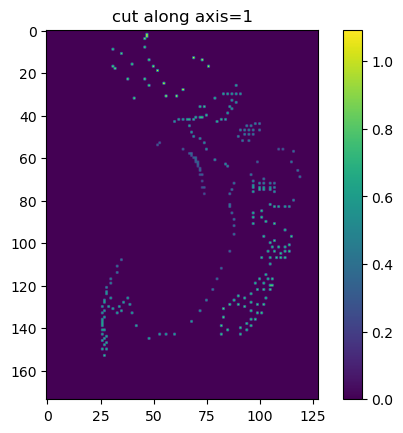

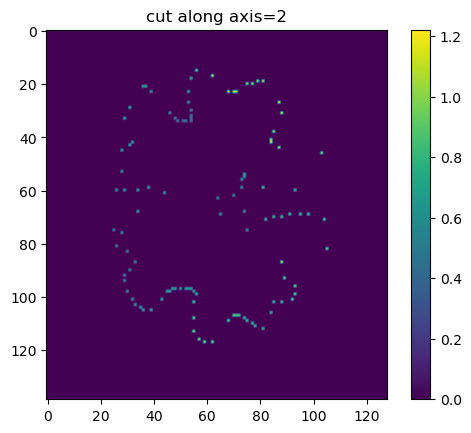

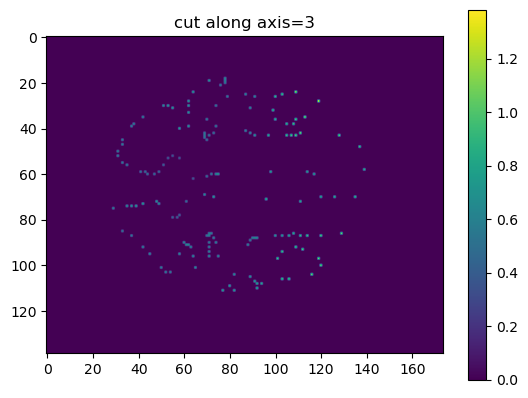

In [62]:
X4_3dvox = torch.load("/niddk-data-central/mae_hr/FVE/CNN_data_out/X4.pt")
print(X4_3dvox.shape)

plt.imshow(X4_3dvox[0,60,:,:], cmap=None)
plt.title("cut along axis=1")
plt.colorbar()
plt.show()

plt.imshow(X4_3dvox[0,:,130,:])
plt.title("cut along axis=2")
plt.colorbar()
plt.show()

plt.imshow(X4_3dvox[0,:,:,100])
plt.title("cut along axis=3")
plt.colorbar()
plt.show()

In [ ]:
!pip install natsort

In [55]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import glob
import os
from natsort import natsorted



class TensorDatasetFromFiles(Dataset):
    def __init__(self, data_dir, normalize=True, transform=None):
        self.X = torch.load(os.path.join(data_dir, 'X_train_tensor.pt'))
        self.X = natsorted(glob.glob(os.path.join(data_dir, 'X*.pt')))
        self.y = torch.load(os.path.join(data_dir, "y_train_tensor.pt"))

        self.transform = transform
        self.normalize = normalize


        if self.normalize:
            y_tensor = self.y
            y_tensor = (y_tensor - y_tensor.mean())/y_tensor.std()
            self.y = y_tensor
        
        assert len(self.X) == len(self.y), \
            "Number of input files must match the number of target samples"

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample_X = torch.load(self.X[idx])
        #sample_X = self.X[idx]#.squeeze(0)#.permute(2,0,1)
        sample_y = self.y[idx].unsqueeze(-1)#.squeeze(0)#.permute(2,0,1)

        if self.transform:
            sample_X = self.transform(sample_X)
        
        return sample_X, sample_y


# Paths to your data
data_dir="/niddk-data-central/mae_hr/FVE/CNN_data_out"



# Create dataset and dataloader
dataset = TensorDatasetFromFiles(data_dir, transform=None)

ModuleNotFoundError: No module named 'natsort'